In [17]:
import itertools
import joblib
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Load dataset

In [18]:
# Get data 

import pandas as pd
from sklearn.datasets import load_iris
from pathlib import Path

raw_data_path = Path('data/raw/')
raw_data_path.mkdir(parents=True, exist_ok=True)

processed_data_path = Path('data/processed/')
processed_data_path.mkdir(parents=True, exist_ok=True)

data = load_iris(as_frame=True)
dataset = data.frame
dataset.to_csv(raw_data_path / 'iris.csv', index=False)
dataset.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [19]:
# print labels for target values 

[print(f'{target}: {label}') for target, label in zip(data.target.unique(), data.target_names)]

0: setosa
1: versicolor
2: virginica


[None, None, None]

In [20]:
# feature names

dataset.columns = [colname.strip(' (cm)').replace(' ', '_') for colname in dataset.columns.tolist()]

feature_names = dataset.columns.tolist()[:4]
feature_names

['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# Features engineering

In [21]:
dataset['sepal_length_to_sepal_width'] = dataset['sepal_length'] / dataset['sepal_width']
dataset['petal_length_to_petal_width'] = dataset['petal_length'] / dataset['petal_width']

dataset = dataset[[
    'sepal_length', 'sepal_width', 'petal_length', 'petal_width',
#     'sepal_length_in_square', 'sepal_width_in_square', 'petal_length_in_square', 'petal_width_in_square',
    'sepal_length_to_sepal_width', 'petal_length_to_petal_width',
    'target'
]]

In [22]:
dataset.head()

,sepal_length,sepal_width,petal_length,petal_width,sepal_length_to_sepal_width,petal_length_to_petal_width,target
0,5.1,3.5,1.4,0.2,1.457143,7.0,0
1,4.9,3.0,1.4,0.2,1.633333,7.0,0
2,4.7,3.2,1.3,0.2,1.468750,6.5,0
3,4.6,3.1,1.5,0.2,1.483871,7.5,0
4,5.0,3.6,1.4,0.2,1.388889,7.0,0


In [23]:
# Save features
dataset.to_csv(processed_data_path / 'featured_iris.csv', index=False)

# Split dataset

In [24]:
random_state = 42
test_size = 0.2

train_dataset, test_dataset = train_test_split(dataset, test_size=test_size, random_state=random_state)
train_dataset.shape, test_dataset.shape

((120, 7), (30, 7))

In [25]:
# Save train and test sets
trainset_path = processed_data_path / 'train_iris.csv'
testset_path = processed_data_path / 'test_iris.csv'

train_dataset.to_csv(trainset_path)
test_dataset.to_csv(testset_path)

# Train

In [26]:
# Get X and Y

y_train = train_dataset.loc[:, 'target'].values.astype('int32')
X_train = train_dataset.drop('target', axis=1).values.astype('float32')

In [27]:
# Create an instance of Logistic Regression Classifier CV and fit the data
clf_params = {
    'C': 0.001,
    'solver': 'lbfgs',
    'multi_class': 'multinomial',
    'max_iter': 100
}

logreg = LogisticRegression(**clf_params, random_state=random_state)
logreg.fit(X_train, y_train)

/home/sergio.sampayo/.cache/pypoetry/virtualenvs/dvc-playground-x0Kf_gpz-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(C=0.001, multi_class='multinomial', random_state=42)

In [28]:
model_path= 'models/model.joblib'
joblib.dump(logreg, model_path)

['models/model.joblib']

# Evaluate

In [29]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [30]:
# Get X and Y

y_test = test_dataset.loc[:, 'target'].values.astype('int32')
X_test = test_dataset.drop('target', axis=1).values.astype('float32')

In [31]:
prediction = logreg.predict(X_test)
cm = confusion_matrix(prediction, y_test)
f1 = f1_score(y_true = y_test, y_pred = prediction, average='macro')

In [32]:
# f1 score value
f1

0.9305555555555555

In [34]:
# Save metrics
reports_path = Path('reports/')
reports_path.mkdir(parents=True, exist_ok=True)

metrics_file = reports_path / 'metrics.json'

metrics = {
    'f1': f1
}

with open(metrics_file, 'w') as mf:
    json.dump(
        obj=metrics,
        fp=mf,
        indent=4
    )

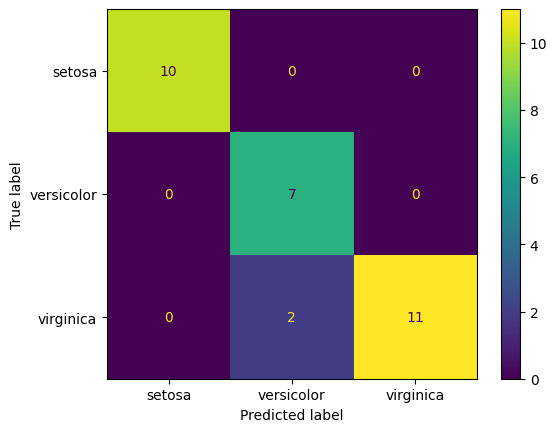

In [60]:
from sklearn import metrics

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels = ["setosa", "versicolor", "virginica"])
cm_display.plot()
plt.savefig(reports_path / 'confusion_matrix.png')
plt.show()